# Initial setup

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import pickle

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load saved keys from API key file
keys = pickle.load(open('api_key.p', 'rb'))
auth = tw.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tw.API(auth, wait_on_rate_limit=True)

# Get trending topics

In [14]:
# See available regions
# api.trends_available() # worldwide has woeid (Where On Earth IDentifier) of 1; US of 23424977

# Get worldwide trending topics
trends1 = api.trends_place(23424977) # 23424977 is the US

# Extract topic name and number of tweets for each
trends = [(trend['name'], trend['tweet_volume']) for trend in trends1[0]['trends']]

# Create pandas df
trends_df = pd.DataFrame(trends, columns=['Topic', 'Count'])
trends_df.head(10)

,Topic,Count
0,Jersey City,69183.0
1,#BROCKHAMPTON,24373.0
2,Mac Pro,15685.0
3,Barr,552681.0
4,#ripnickcannon,63116.0
5,#ImpeachAndConvictTrump,33755.0
6,#HumanRightsDay,201591.0
7,Lauren London,18961.0
8,#TuesdayThoughts,74824.0
9,USMCA,171813.0


# Use API to download tweets

In [39]:
# Download tweets based on a specific trending topic using API (slow)

# Specify topic of interest
topic = trends_df.Topic[0] # Jersey City
search_term = topic + ' -filter:retweets'

# Get tweets
tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2019-12-09').items(10) # Only 10 for now

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]

['Officer, 5 Others Dead in ‘Ambush’ NJ Active Shooter Situation – NBC10 Philadelphia https://t.co/3HvBihfEWF',
 'Is it just coincidence that there have been multiple shootouts with police since Barr issues his veiled threat abou… https://t.co/dYbZh7LYeT',
 'Jersey City will release them future convicts at 4 https://t.co/28erQztlwC',
 'Pray for the active shooter in Jersey City happening live righty now. They have all schools on lockdown and advisin… https://t.co/oWcPbCwxyJ',
 'The lockdown in the Jersey City Public Schools will be lifted at 4:15pm. Please give the administrators and educato… https://t.co/WADMqxMgya']

# GetOldTweets to download tweets
Based on: https://github.com/fajarmf10/GetOldTweets-python and https://github.com/Jefferson-Henrique/GetOldTweets-python/issues/52#issuecomment-276932885

Steps taken:
- git clone https://github.com/Jefferson-Henrique/GetOldTweets-python
- cd GetOldTweets-python
- mv got3 ~/anaconda3/lib/python3.7/site-packages
- pip install pyquery

In [7]:
# Get old tweets
import got3

In [41]:
# Download tweets using GetOldTweets instead of API
# Specify trending topic of interest
topic = trends_df.Topic[0] # Jersey City
numTweets = 200 # How many tweets to scrape (about 20 per s)
tweetCriteria = got3.manager.TweetCriteria().setQuerySearch(topic).setLang('english').setSince('2019-12-10').setUntil('2019-12-11').setMaxTweets(numTweets)

# Get tweets
tweets = got3.manager.TweetManager.getTweets(tweetCriteria)

# Create pandas df
all_tweets_df = pd.DataFrame([], columns=['ID', 'Link', 'Username', 'Text',
                                          'Date', 'Retweets', 'Favorites',
                                          'Mentions', 'Hashtags', 'Geo',
                                          'URLs', 'Author_ID'])
for i in range(numTweets):
    all_tweets_df.loc[i] = [tweets[i].id, tweets[i].permalink, tweets[i].username, tweets[i].text,
                            tweets[i].date, tweets[i].retweets, tweets[i].favorites,
                            tweets[i].mentions, tweets[i].hashtags, tweets[i].geo,
                            tweets[i].urls, tweets[i].author_id]
all_tweets_df.head()

,ID,Link,Username,Text,Date,Retweets,Favorites,Mentions,Hashtags,Geo,URLs,Author_ID
0,1204509144331563009,https://twitter.com/l_negro/status/12045091443...,,@ReneFranco @Adela_Micha Varios muertos y heri...,2019-12-10 16:12:13,0,0,@ReneFranco @Adela_Micha @univisionNY,,,http://uni.vi/CK0W1023dHY,65217844
1,1204509142179893248,https://twitter.com/OneJerseySchorr/status/120...,,Can also confirm that at least five people are...,2019-12-10 16:12:12,0,0,,#JerseyCity,,,330800523
2,1204509140594413575,https://twitter.com/Vespertilio65/status/12045...,,"@ememess Michael, I’m losing it today. Lavrov ...",2019-12-10 16:12:12,0,0,@ememess,,,https://twitter.com/danqbrut/status/1204448999...,875433552380391425
3,1204509138090430464,https://twitter.com/jmc321qwe/status/120450913...,,"JERSEY CITY ACTIVE SHOOTING: 5 Dead, Including...",2019-12-10 16:12:11,0,0,@breaking911,,,https://breaking911.com/breaking-active-shoote...,2379518203
4,1204509134659477505,https://twitter.com/real_diculous/status/12045...,,Jersey City to dismiss students finally at 415pm,2019-12-10 16:12:11,0,0,,,,,221051882


# Basic EDA of 'Text'

In [50]:
# Function to standardize text (make lowercase and remove URLs, mentions, and non-alphanumeric characters)
def standardize_text(df):
    df = df.str.lower() # Make everything lowercase
    df = df.str.replace(r"http\S+", "") # Remove URLs
    df = df.str.replace(r"[A-Za-z]+.com/\S+", "") # Remove URLs
    df = df.str.replace(r"http", "") # Remove "http"s
    df = df.str.replace(r"pic.twitter.com\S+", "") # Remove "pic.twitter.com"s
    df = df.str.replace(r"@\S+", "") # Remove mentions
    df = df.str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") # Remove any non-alphanumeric chars
    df = df.str.replace(r"@", "at") # Replace "@" with "at"
    return df

# Clean up 'Text'
clean_tweets = standardize_text(all_tweets_df['Text'])
clean_tweets[:5]

0      varios muertos y heridos en supermercado don...
1    can also confirm that at least five people are...
2     michael, i m losing it today  lavrov in the w...
3    jersey city active shooting  5 dead, including...
4     jersey city to dismiss students finally at 415pm
Name: Text, dtype: object

In [51]:
# Create a list of lists containing words for each tweet
words_in_tweet = [tweet.split() for tweet in clean_tweets]

# Set stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Add query words to stopwords
stop_words.extend(topic.lower().split(' '))

# Remove stopwords
tweets_nsw = [[word for word in tweet_words if word not in stop_words]
              for tweet_words in words_in_tweet]

# Determine all words used
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create counter of words in tweets
counts_nsw = collections.Counter(all_words_nsw)

# Create dataframe for counter
clean_tweets_df = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
clean_tweets_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amywen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,words,count
0,shooting,66
1,police,59
2,officer,55
3,shooter,44
4,active,43


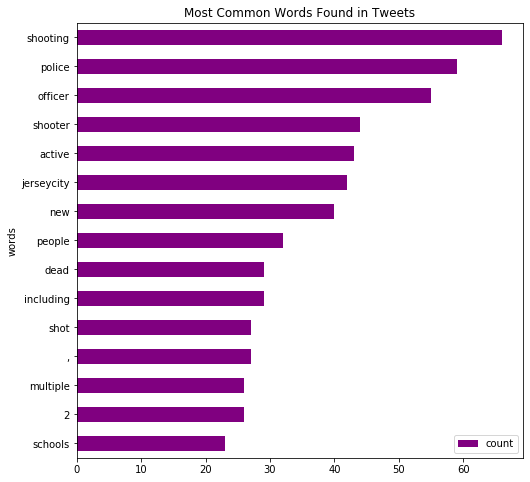

In [52]:
# Plot horizontal bar graph of most frequent words
fig, ax = plt.subplots(figsize=(8, 8))

clean_tweets_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets")

plt.show()

# Find most retweeted tweet

In [21]:
# Specify trending topic of interest
topic = trends_df.Topic[0] # Jersey City
topic = 'Jersey City'

# Also get retweets
retweet_topic = topic + ' filter:nativeretweets'

# Specify tweet criteria
numTweets = 200 # How many tweets to scrape (about 20 per s)
tweetCriteria = got3.manager.TweetCriteria().setQuerySearch(retweet_topic).setLang('en').setSince('2019-12-10').setUntil('2019-12-11').setMaxTweets(numTweets)

# Get tweets
tweets = got3.manager.TweetManager.getTweets(tweetCriteria)

# Create pandas df
all_tweets_df = pd.DataFrame([], columns=['ID', 'Link', 'Username', 'Text',
                                          'Date', 'Retweets', 'Favorites',
                                          'Mentions', 'Hashtags', 'Geo',
                                          'URLs', 'Author_ID'])
for i in range(numTweets):
    all_tweets_df.loc[i] = [tweets[i].id, tweets[i].permalink, tweets[i].username, tweets[i].text,
                            tweets[i].date, tweets[i].retweets, tweets[i].favorites,
                            tweets[i].mentions, tweets[i].hashtags, tweets[i].geo,
                            tweets[i].urls, tweets[i].author_id]
all_tweets_df.head()

,ID,Link,Username,Text,Date,Retweets,Favorites,Mentions,Hashtags,Geo,URLs,Author_ID
0,1204535420303761408,https://twitter.com/ChrisThomsBauer/status/120...,,"As of September 29, there were seven homicides...",2019-12-10 17:56:38,1,0,,#JerseyCityShooting,,https://twitter.com/redsteeze/status/120448201...,822271632383295493
1,1204516557730275332,https://twitter.com/realDonaldTrump/status/120...,,Just received a briefing on the horrific shoot...,2019-12-10 16:41:40,7197,29856,,,,,1149063172273377282
2,1204534150759374848,https://twitter.com/shaunking/status/120453415...,,"'Multiple’ people dead, others injured in Jers...",2019-12-10 17:51:35,10,7,,,,https://twitter.com/i/events/1204473109979357185,123662382
3,1204511653863153665,https://twitter.com/209acesheepdog/status/1204...,,"Sheepdogs Jersey City Police Officer Killed, 2...",2019-12-10 16:22:11,25,9,@209acesheepdog @1acemadsen1 @epochtimes,,,https://www.theepochtimes.com/2-jersey-city-po...,966317909659103232
4,1204516557730275332,https://twitter.com/realDonaldTrump/status/120...,,Just received a briefing on the horrific shoot...,2019-12-10 16:41:40,7197,29856,,,,,899498052297400320


In [28]:
# Order by most retweets
retweet_order_all_tweets_df = all_tweets_df.sort_values(by='Retweets', ascending=False).reset_index(drop=True)

# Order by most favorites
favorites_order_all_tweets_df = all_tweets_df.sort_values(by='Favorites', ascending=False).reset_index(drop=True)

# Most retweeted tweet
print('Most retweeted tweet:\n', retweet_order_all_tweets_df.loc[0, 'Text'], '\n',
      retweet_order_all_tweets_df.loc[0, 'Link'], sep='')

# Most favorited tweet
print('\nMost favorited tweet:\n', favorites_order_all_tweets_df.loc[0, 'Text'], '\n',
      favorites_order_all_tweets_df.loc[0, 'Link'], sep='')

Most retweeted tweet:
This is America. The only high income country in the world that allows gun lobbyists to write its nation’s gun laws. Jersey City pic.twitter.com/NIhhNoBdhR
https://twitter.com/shannonrwatts/status/1204475965973266432

Most favorited tweet:
Just received a briefing on the horrific shootout that took place in Jersey City , NJ. Our thoughts & prayers are w/ the victims & their families during this very difficult & tragic time. We will continue to monitor the situation as we assist local & state officials on the ground.
https://twitter.com/realDonaldTrump/status/1204516557730275332
